# Nuclei segmentation

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage
import spateo as st
from scipy import ndimage

plt.rcParams['image.interpolation'] = 'none'
%config InlineBackend.figure_format='retina'

/Users/josephmin/miniconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/Users/josephmin/miniconda3/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:366: NumbaWarning: The TBB threading layer requires TBB version 2021 update 1 or later i.e., TBB_INTERFACE_VERSION >= 12010. Found TBB_INTERFACE_VERSION = 11102. The TBB threading layer is disabled.
  warnings.warn(problem)
OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/josephmin/miniconda3/lib/python3.9/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtime

## Load the data

In [2]:
tif = skimage.io.imread('data/SS200000135IL-D1.ssDNA.tif')
total, exonic, intronic = st.read_bgi_agg('data/SS200000135TL_D1_all_bin1.txt.gz')

Text(0.5, 1.0, 'intronic')

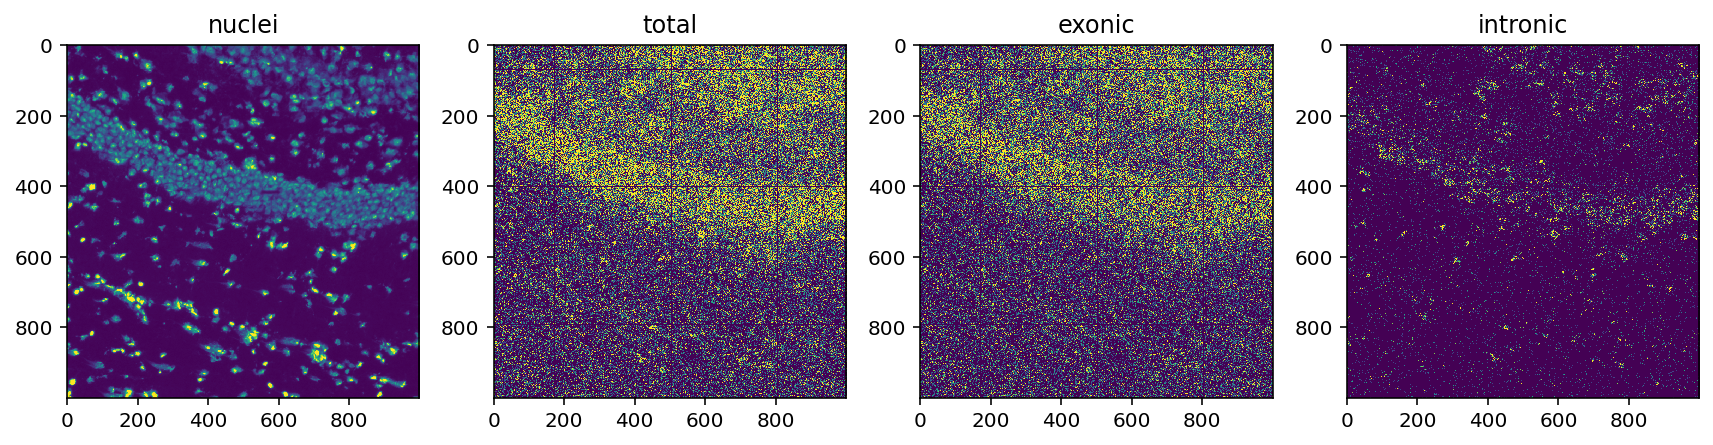

In [3]:
fig, axes = plt.subplots(ncols=4, figsize=(12, 3), tight_layout=True)
axes[0].imshow(tif)
axes[0].set_title('nuclei')
axes[1].imshow(total.A, vmin=0, vmax=5)
axes[1].set_title('total')
axes[2].imshow(exonic.A, vmin=0, vmax=5)
axes[2].set_title('exonic')
axes[3].imshow(intronic.A, vmin=0, vmax=5)
axes[3].set_title('intronic')

## Segmentation using stained nuclei

Segmenting nuclei from staining result is relatively easy, since all we have to do is threshold the image to obtain a nuclei mask, and assign the mask to individual nuclei with watershed.

First, we will apply a global threshold using multi-class Otsu thresholding. This will classify each pixel into one of three bins based on all the intensities present in the image. We take all the pixels that are below the first threshold (i.e. classified into the first bin) to be background.

Text(0.5, 1.0, 'background segmentation')

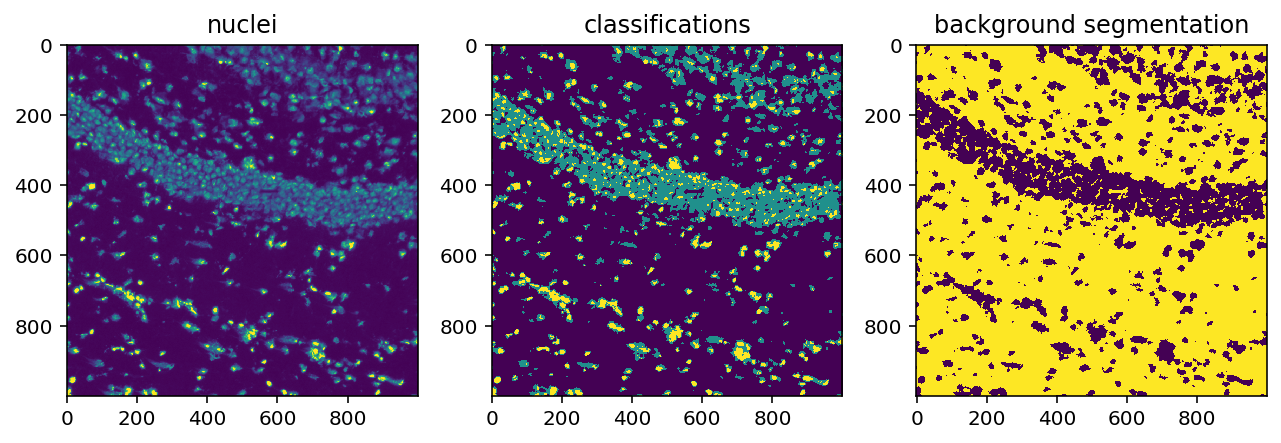

In [4]:
thresholds = skimage.filters.threshold_multiotsu(tif, 3)
regions = np.digitize(tif, bins=thresholds)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), tight_layout=True)
axes[0].imshow(tif)
axes[0].set_title('nuclei')

axes[1].imshow(regions)
axes[1].set_title('classifications')

background_mask = tif <= thresholds[0]
axes[2].imshow(background_mask)
axes[2].set_title('background segmentation')

Then, we separately apply a local (adaptive) thresholding method, which uses the local neighborhood of each pixel to determine the threshold for that pixel. This method is usually quite accurate (especially for images that have highly variable nuclei density), but becomes noisy in sparse areas.

Text(0.5, 1.0, 'local segmentation')

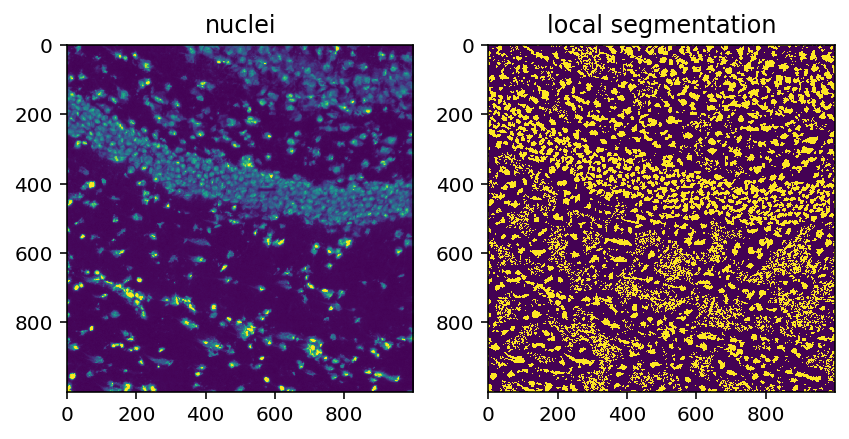

In [5]:
local_mask = tif > skimage.filters.threshold_local(tif, 45)
fig, axes = plt.subplots(ncols=2, figsize=(6, 3), tight_layout=True)
axes[0].imshow(tif)
axes[0].set_title('nuclei')

axes[1].imshow(local_mask)
axes[1].set_title('local segmentation')

Now, we use both the background mask (obtained via global thresholding) and the cell mask (obtained via local thresholding) to obtain the final mask.

Text(0.5, 1.0, 'nuclei segmentation')

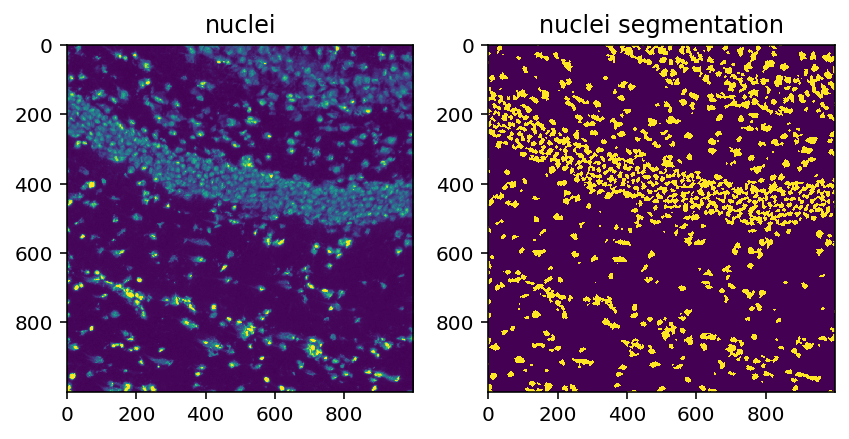

In [6]:
nuclei_mask = st.pp.segmentation.utils.mclose_mopen(
    (~background_mask) & local_mask, 5
)

fig, axes = plt.subplots(ncols=2, figsize=(6, 3), tight_layout=True)
axes[0].imshow(tif)
axes[0].set_title('nuclei')

axes[1].imshow(nuclei_mask)
axes[1].set_title('nuclei segmentation')

This does a pretty good job at identifying where nuclei are, but there are some noisy areas and regions where multiple nuclei are connected. We would like to separate individual nuclei. We can do so by using the Watershed algorithm. Note that this algorithm relies on a set of "markers" which will serve as seed regions for segmentation. Therefore, finding good markers is very important.

Text(0.5, 1.0, 'markers')

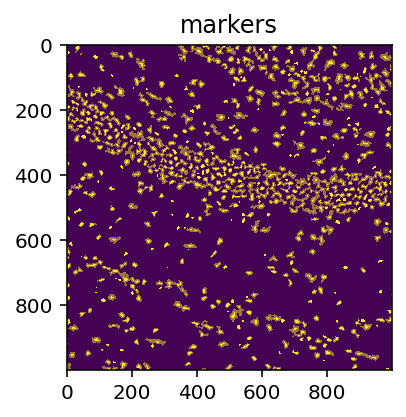

In [21]:
eroded = st.pp.segmentation.utils.erode_safe(
    nuclei_mask, 3, square=True, min_area=100, n_iter=5
)

fig, ax = plt.subplots(figsize=(3, 3), tight_layout=True)
ax.imshow(nuclei_mask)
ax.imshow(eroded, alpha=0.5)
ax.set_title('markers')

Text(0.5, 1.0, 'final segmentation')

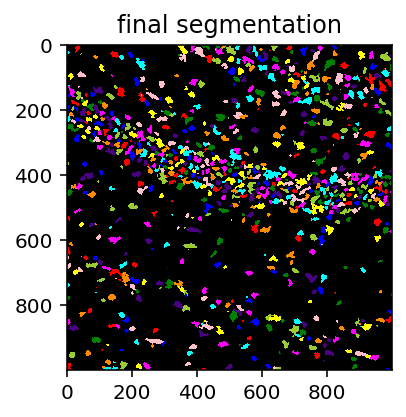

In [23]:
markers = cv2.connectedComponents(eroded.astype(np.uint8))[1]
watershed = skimage.segmentation.watershed(-tif, markers, mask=nuclei_mask)

fig, ax = plt.subplots(figsize=(3, 3), tight_layout=True)
ax.imshow(skimage.color.label2rgb(watershed, bg_label=0))
ax.set_title('final segmentation')

## Segmentation using (intronic) RNA signal

When stained nuclei are not available, it is possible to identify nuclei using intronic RNA. This approach, however, relies on the mis-priming of pre-processed intronic RNA onto the polyA nanoballs. Therefore, it is not reasonable to expect that we will be able to identify nearly as many nuclei as we did with the staining image due to overall low (intron) capture rate, technical and biological noise, and RNA diffusion.

In [ ]:
# TODO

In [155]:
scores = st.pp.segmentation.icell.score_pixels(
    intronic,
    k=5,
    method='EM+BP',
    em_kwargs=dict(downsample=100000),
    bp_kwargs=dict(n_threads=8, k=3, square=False, p=0.7, q=0.3),
)

Text(0.5, 1.0, 'segmentation')

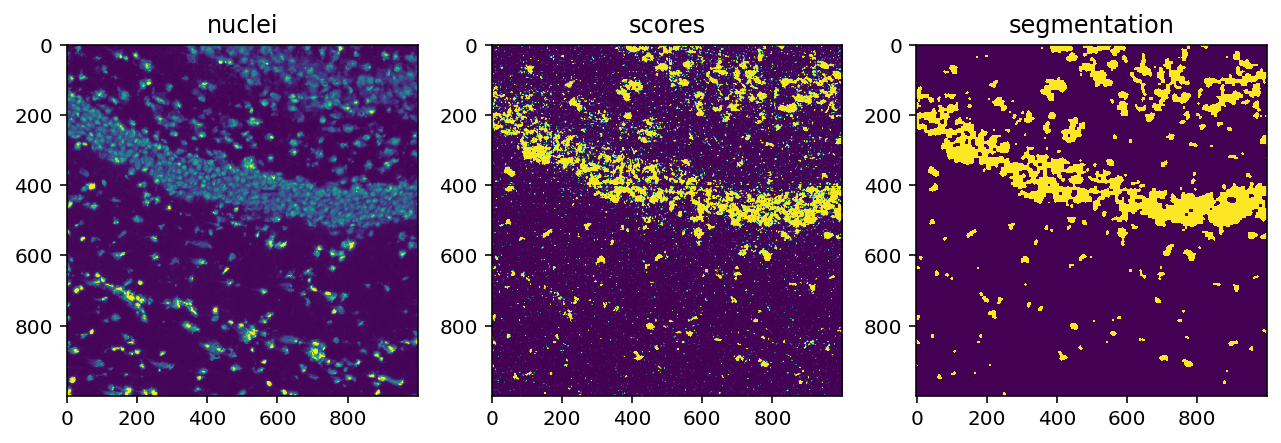

In [156]:
nuclei = st.pp.segmentation.icell.apply_threshold(scores, 7, skimage.filters.threshold_otsu(scores))

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), tight_layout=True)
axes[0].imshow(tif)
axes[0].set_title('nuclei')
axes[1].imshow(scores, vmin=0, vmax=1)
axes[1].set_title('scores')
axes[2].imshow(nuclei, vmin=0, vmax=1)
axes[2].set_title('segmentation')

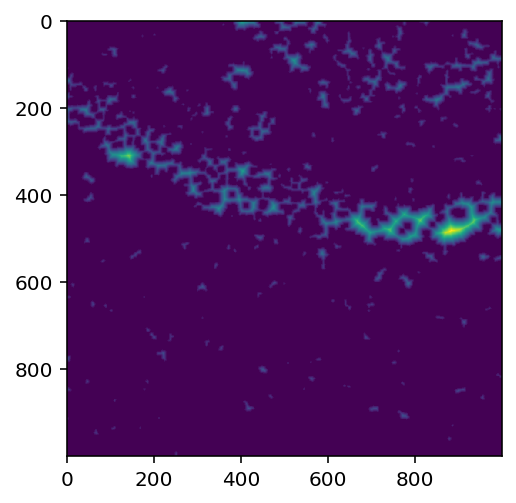

In [157]:
distances = cv2.distanceTransform(nuclei.astype(np.uint8), cv2.DIST_L2, 0)
plt.imshow(distances)

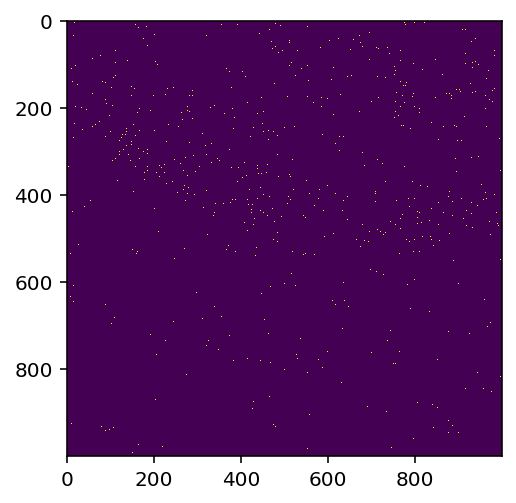

In [237]:
blur = st.pp.segmentation.utils.conv2d(intronic.A, 7, mode='gauss')
peaks = skimage.feature.peak_local_max(blur, min_distance=3, threshold_abs=0.5)
peak_mask = np.zeros_like(distances, dtype=bool)
peak_mask[tuple(peaks.T)] = True
plt.imshow(peak_mask)

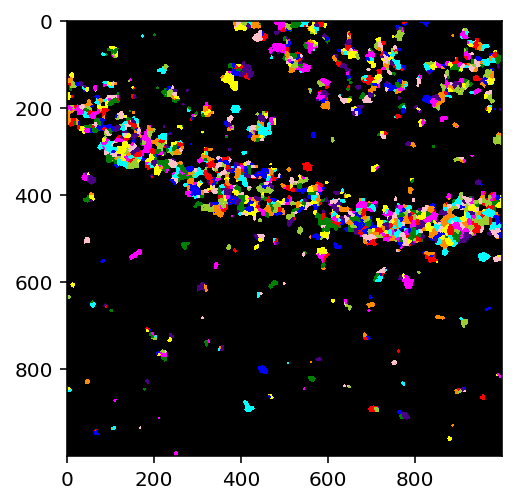

In [238]:
markers = skimage.measure.label(peak_mask)
segment = skimage.segmentation.watershed(-scores, markers, mask=nuclei)
plt.imshow(skimage.color.label2rgb(segment))

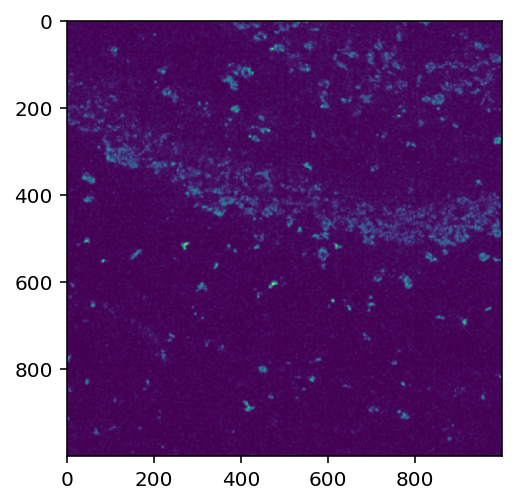

In [200]:
plt.imshow(blur)

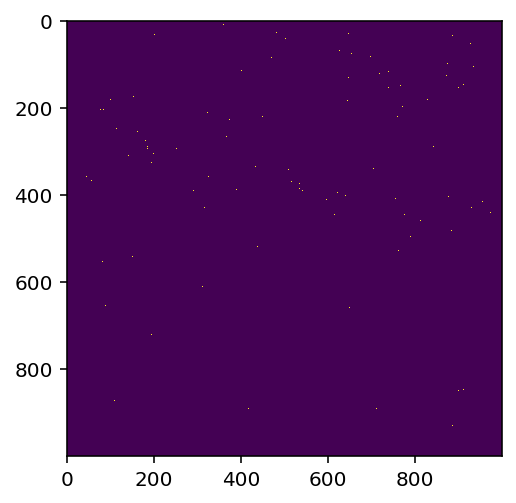

In [163]:
peaks = skimage.feature.peak_local_max(distances, min_distance=5)
peak_mask = np.zeros_like(distances, dtype=bool)
peak_mask[tuple(peaks.T)] = True
plt.imshow(peak_mask)

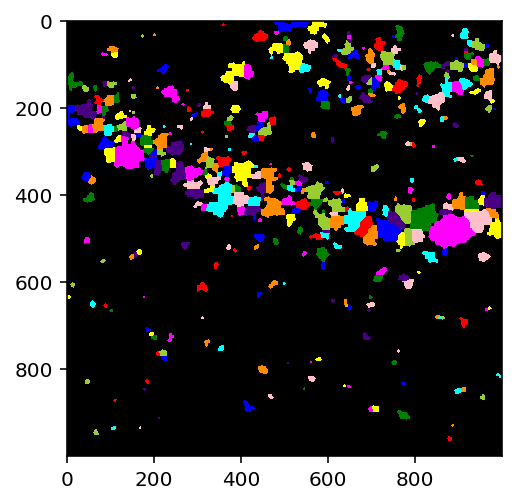

In [164]:
markers = skimage.measure.label(peak_mask)
segment = skimage.segmentation.watershed(-distances, markers, mask=nuclei)
plt.imshow(skimage.color.label2rgb(segment))

array([[486, 870],
       [489, 878],
       [490, 881],
       ...,
       [264,  88],
       [496, 562],
       [413, 600]])

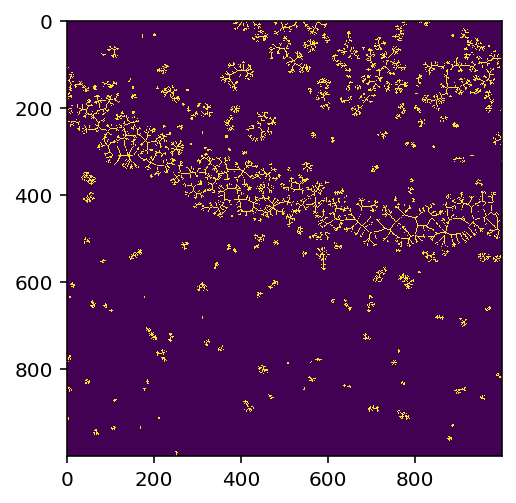

In [94]:
plt.imshow(distances > skimage.filters.threshold_local(distances))

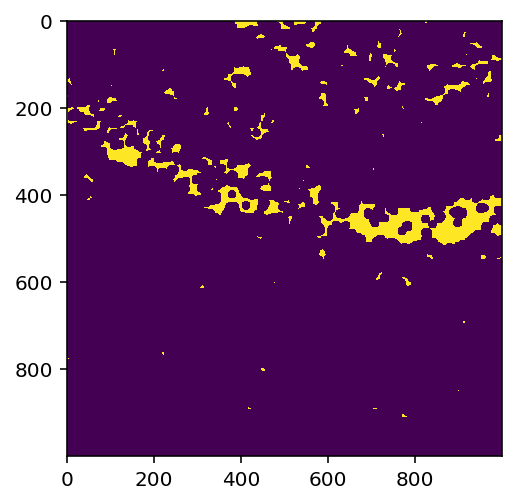

In [92]:
plt.imshow(distances > distances.max() * 0.2)

190

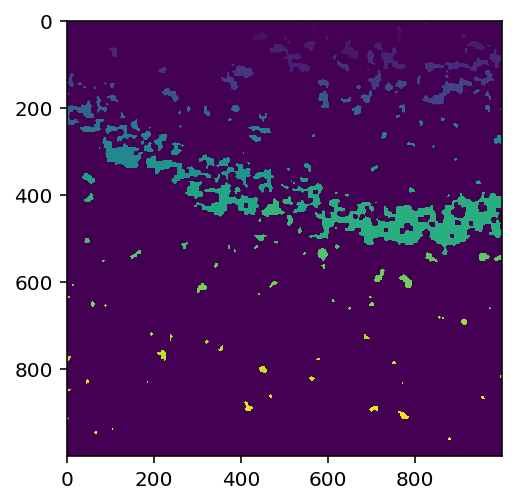

In [68]:
eroded = skimage.morphology.erosion(nuclei)
labels, count = ndimage.label(eroded)
plt.imshow(labels)
count

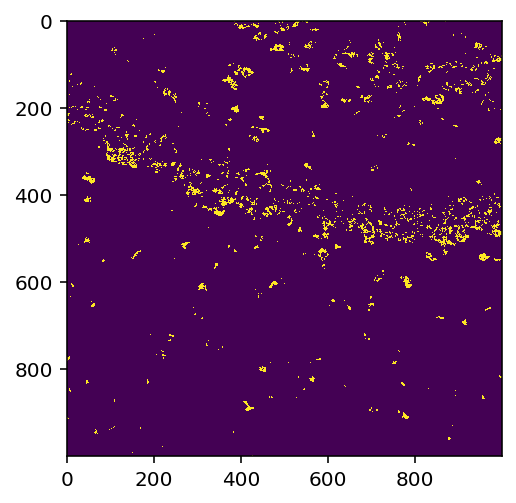

In [203]:
plt.imshow(scores > 0.999)

In [58]:
nuclei.astype(np.uint8)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [26]:
nuclei = st.pp.segmentation.icell.apply_threshold(scores, 7, 0.99)

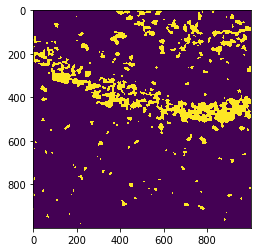

In [27]:
plt.imshow(nuclei)

In [ ]:
skimage.filters.threshold_multiotsu(scores, 6)